In [1]:
import pandas as pd
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from pprint import pprint

## If you also need to run the alignment of titered strains:
# from Bio.Alphabet import DNAAlphabet
# from Bio import SeqIO
# from Bio.Seq import Seq
# import os

In [2]:
titerfile = open('/Users/Sidney/nextstrain/fauna/data/dengue_titers.tsv', 'r')
alignmentfile = open('./smith_E_prot_aln.fasta', 'r')

In [3]:
## Read in, parse titer datafile (augur format tsv)
raw_titers = pd.read_csv(titerfile, sep='\t', header=None,
                    names=['virus', 'serum', 'serumID', 'src', 'titer'])
raw_titers['serumID'].replace('DENV.*', 'agm', regex=True, inplace=True) # All the values with the strain name as serum ID are from AGMs
raw_titers['serumID'] = raw_titers['serum']+'|'+raw_titers['serumID'] # SerumStrain|patientID or SerumStrain|agm (1 monkey per strain used)
raw_titers.drop('serum', axis=1, inplace=True) # Cleanup
raw_titers.drop('src', axis=1, inplace=True)
raw_titers = raw_titers.to_dict(orient='records') #[{'serumID': 'DENV1/VIETNAM/BIDV1937/2008_agm', 'virus': 'DENV1/BOLIVIA/FSB3363/2010', 'titer': 29}, ...]

In [4]:
serum_strains = list(set([ record['serumID'] for record in raw_titers ]))
virus_strains = list(set([ record['virus'] for record in raw_titers ]))

In [52]:
### Run alignment (if needed; also import extra modules above)

# all_titered_strains = set([s.split('|')[0] for s in serum_strains] + virus_strains)
# all_sequences = { s.description.split('|')[0] : s for s in SeqIO.parse('/Users/Sidney/nextstrain/fauna/data/dengue.fasta', 'fasta')}

# titered_sequences = [ all_sequences[s] for s in all_titered_strains ]
# for s in titered_sequences:
#     s.seq = Seq(str(s.seq).replace('-', ''), alphabet=DNAAlphabet())
#     s.seq.translate()
# SeqIO.write(titered_sequences, open('titered_prot.fasta', 'w'), 'fasta')

# import os
# os.system('mafft titered_prot.fasta > titered_prot_aln.fasta')

0

In [5]:
## Read in protein alignment, calculate divergence values, set order of strains.

prot_aln = AlignIO.read(alignmentfile, 'fasta') # Read in protein alignment
divergence = DistanceCalculator('blosum62').get_distance(prot_aln) # Blosum62 scoring
order = [s.split('|')[0] for s in divergence.names] # Truncate to strain names
divergence = pd.DataFrame(divergence.matrix, columns=order, index=order)

In [12]:
## Make a design matrix formatted dataframe with rows and columns ordered by divergence (i.e., tree order)

serum_strains.sort(key=lambda x: order.index(x.split('|')[0]))
virus_strains.sort(key=lambda x: order.index(x))
raw_titers_matrix = pd.DataFrame(columns=serum_strains, index=virus_strains, dtype=float)
for record in raw_titers:
    raw_titers_matrix.at[record['virus'], record['serumID']] = record['titer']
log2_titers_matrix = raw_titers_matrix.applymap(np.log2) # Put everything on a log2 scale.

In [13]:
def normalize_autologous(series):
    ''' Normalize to autologous titers; return np.nan for columns missing autologous titers.'''
    strain = series.name.split('|')[0]
    if np.isnan(series[strain]):
        return series.map(lambda x: np.nan) # set the whole column to NaN if we're missing the autologous titer; drop it later.
    else:
        autologous = series[strain]
        return series.map(lambda x: autologous - x)

def normalize_max(series):
    ''' Normalize to max value in the row (i.e., the most reactive serum tested). '''
    max_titer = series.max()
    return series.map(lambda x: max_titer - x)

In [14]:
## Normalize both ways, remember to drop empty columns.
autologous_normalized_titers_matrix = log2_titers_matrix.apply(normalize_autologous, axis=0)
autologous_normalized_titers_matrix.dropna(how='all', axis=1, inplace=True) # Drop columns that didn't have an autologous titer.
max_normalized_titers_matrix = log2_titers_matrix.apply(normalize_max, axis=0)

In [15]:
## Cleanup. Once we no longer need to match on names, we can shorten them before making figures.
shortened_names = { s : s.split('/')[0]+'/'+s.split('/')[3] for s in serum_strains+virus_strains }
for matrix in [divergence, raw_titers_matrix, log2_titers_matrix, autologous_normalized_titers_matrix, max_normalized_titers_matrix]:
    matrix.rename(columns=shortened_names, index=shortened_names, inplace=True)

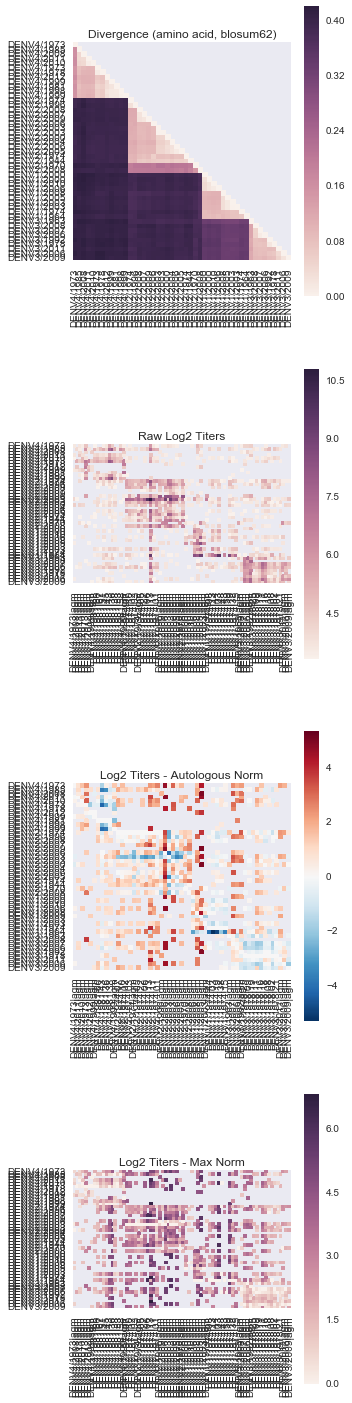

In [21]:
fig, (phylo, raw, autologous_norm, max_norm) = plt.subplots(figsize=(5, 20), nrows=4, ncols=1, facecolor='w')
sns.heatmap(divergence, ax=phylo, square=True)
sns.heatmap(log2_titers_matrix, ax=raw, square=True)
sns.heatmap(autologous_normalized_titers_matrix, ax=autologous_norm, square=True)
sns.heatmap(max_normalized_titers_matrix, ax=max_norm, square=True)

phylo.set_title('Divergence (amino acid, blosum62)')
raw.set_title('Raw Log2 Titers')
autologous_norm.set_title('Log2 Titers - Autologous Norm')
max_norm.set_title('Log2 Titers - Max Norm')

plt.tight_layout()